In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn as nn
import argparse, os, json, sys
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import h5py
from EvalTools import *
sys.path.append("../model")
from PFINDataset import PFINDataset
from UQPFIN import UQPFIN as Model
from EvalTools import uncertainty_plot
import gc
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#optional parameters to only evaluate certain models
optional_dataset = 'jetclass'
optional_tag = ''
results_dir = 'results/'
saved_model_loc = "../model/trained_models/"
saved_model_dict_loc = "../model/trained_model_dicts/"

result_files = sorted([f for f in os.listdir(results_dir) if optional_dataset in f and optional_tag in f
                      and "MCDO" in f and '.h5' in f])
print('\n'.join(result_files))

RESULTS_UQPFIN_MCDO_jetclass_baseline.h5
RESULTS_UQPFIN_MCDO_jetclass_skiph.h5
RESULTS_UQPFIN_MCDO_jetclass_skiptop.h5
RESULTS_UQPFIN_MCDO_jetclass_skiptwz.h5
RESULTS_UQPFIN_MCDO_jetclass_skipwz.h5


In [11]:
for modelname in result_files:
    model_results = {}
    mname = modelname[15:-3]
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")
    labels, preds, oods, probs, uncs = f['labels'][:], f['preds'][:], f['oods'][:], f['probs'][:], f['uncs'][:]
    f.close()
    acc = accuracy_score(labels[~oods], preds[~oods])*100
    if "topdata" in mname:
        probs2=probs
    else:
        skiplabels = np.unique(labels[oods])
        probs2=np.delete(probs, skiplabels, 1)

    if probs2.shape[1] == 2:
        probs2 = probs2[:, 1]
        
    # misclassification detection vs anomaly detection
    if "baseline" in mname:
        oods = labels != preds

    auc = roc_auc_score(oods, uncs) * 100
    del model_results
    gc.collect()
    
    print("{} \t\t Accuracy: {:.2f}% \t AUROC: {:.2f}%".format(mname, acc, auc))    

MCDO_jetclass_baseline 		 Accuracy: 79.29% 	 ROC-AUC: 74.47%
MCDO_jetclass_skiph 		 Accuracy: 81.09% 	 ROC-AUC: 73.87%
MCDO_jetclass_skiptop 		 Accuracy: 75.00% 	 ROC-AUC: 61.48%
MCDO_jetclass_skiptwz 		 Accuracy: 75.53% 	 ROC-AUC: 63.81%
MCDO_jetclass_skipwz 		 Accuracy: 77.72% 	 ROC-AUC: 73.04%


MCDO_jetclass_baseline


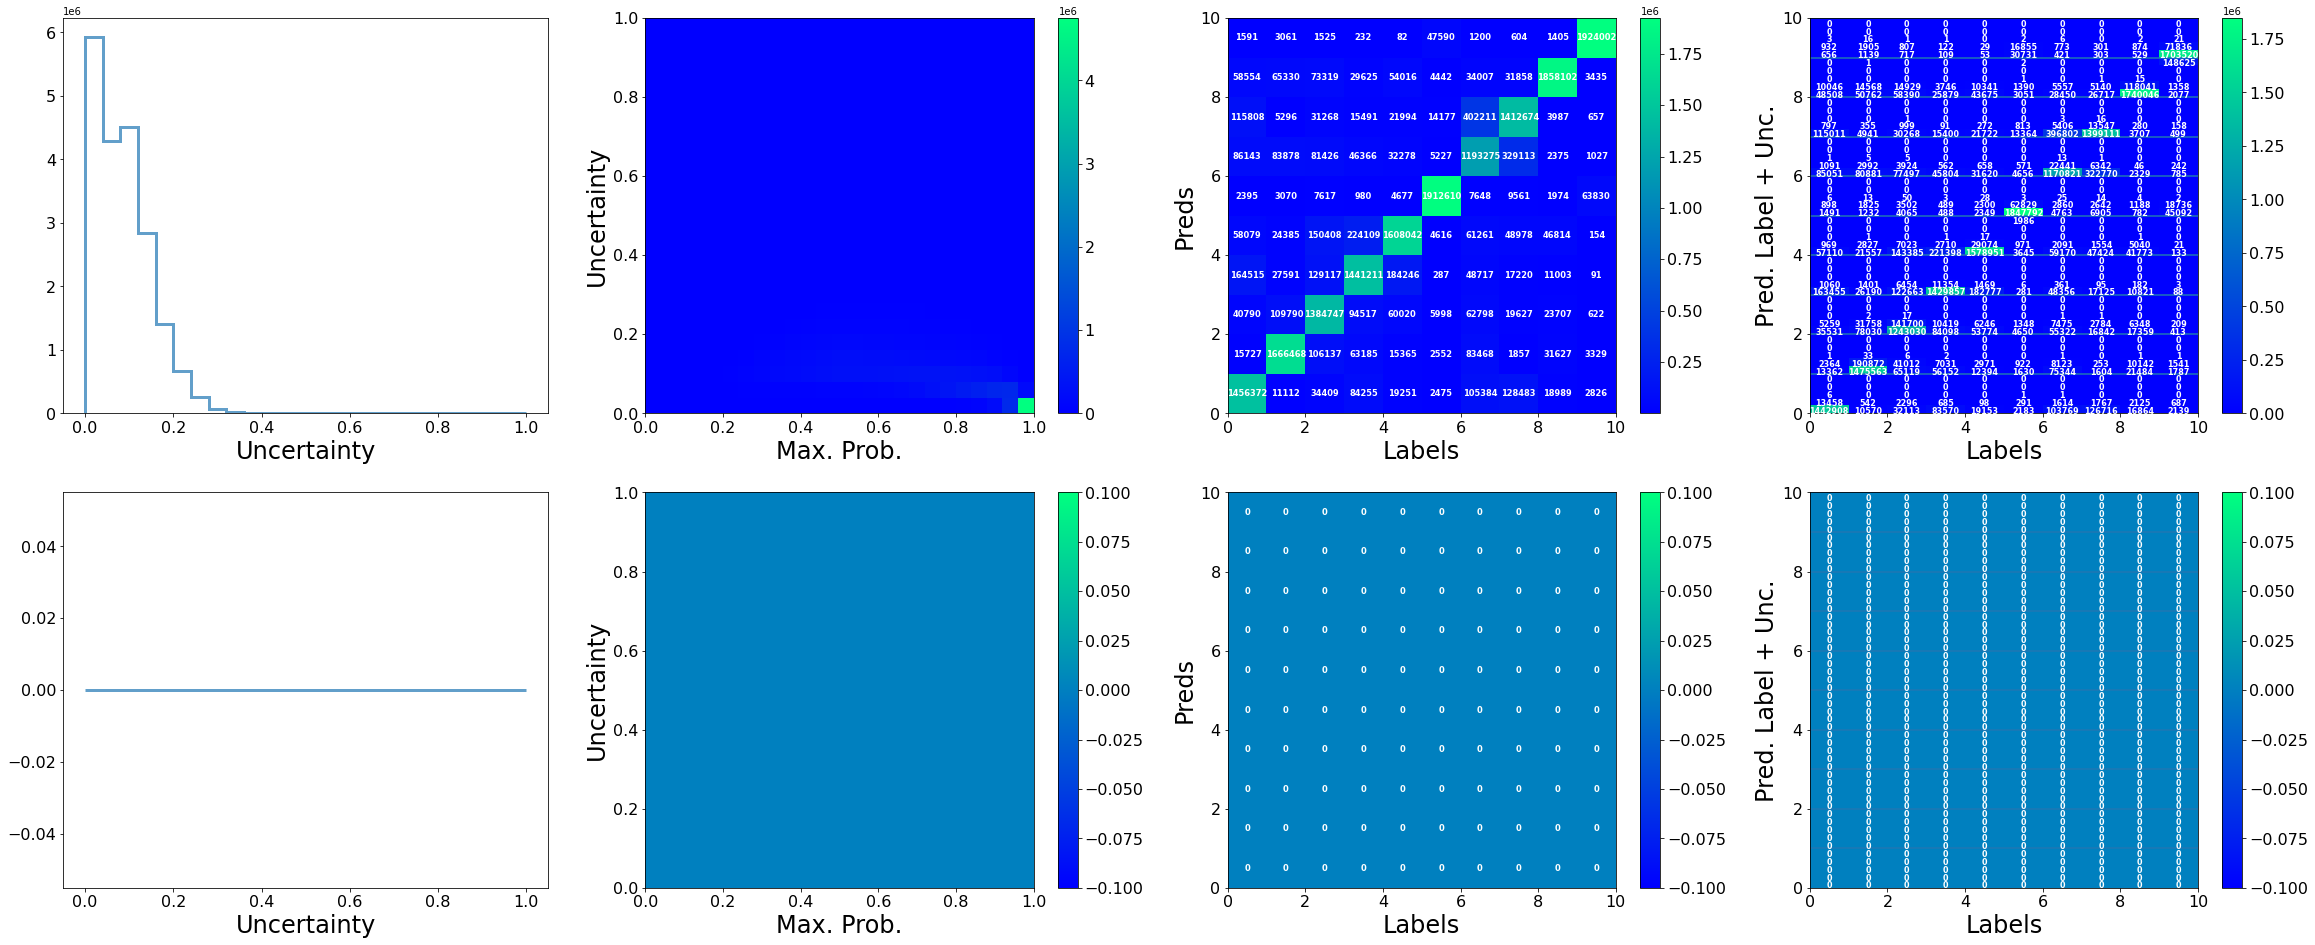

MCDO_jetclass_skiph


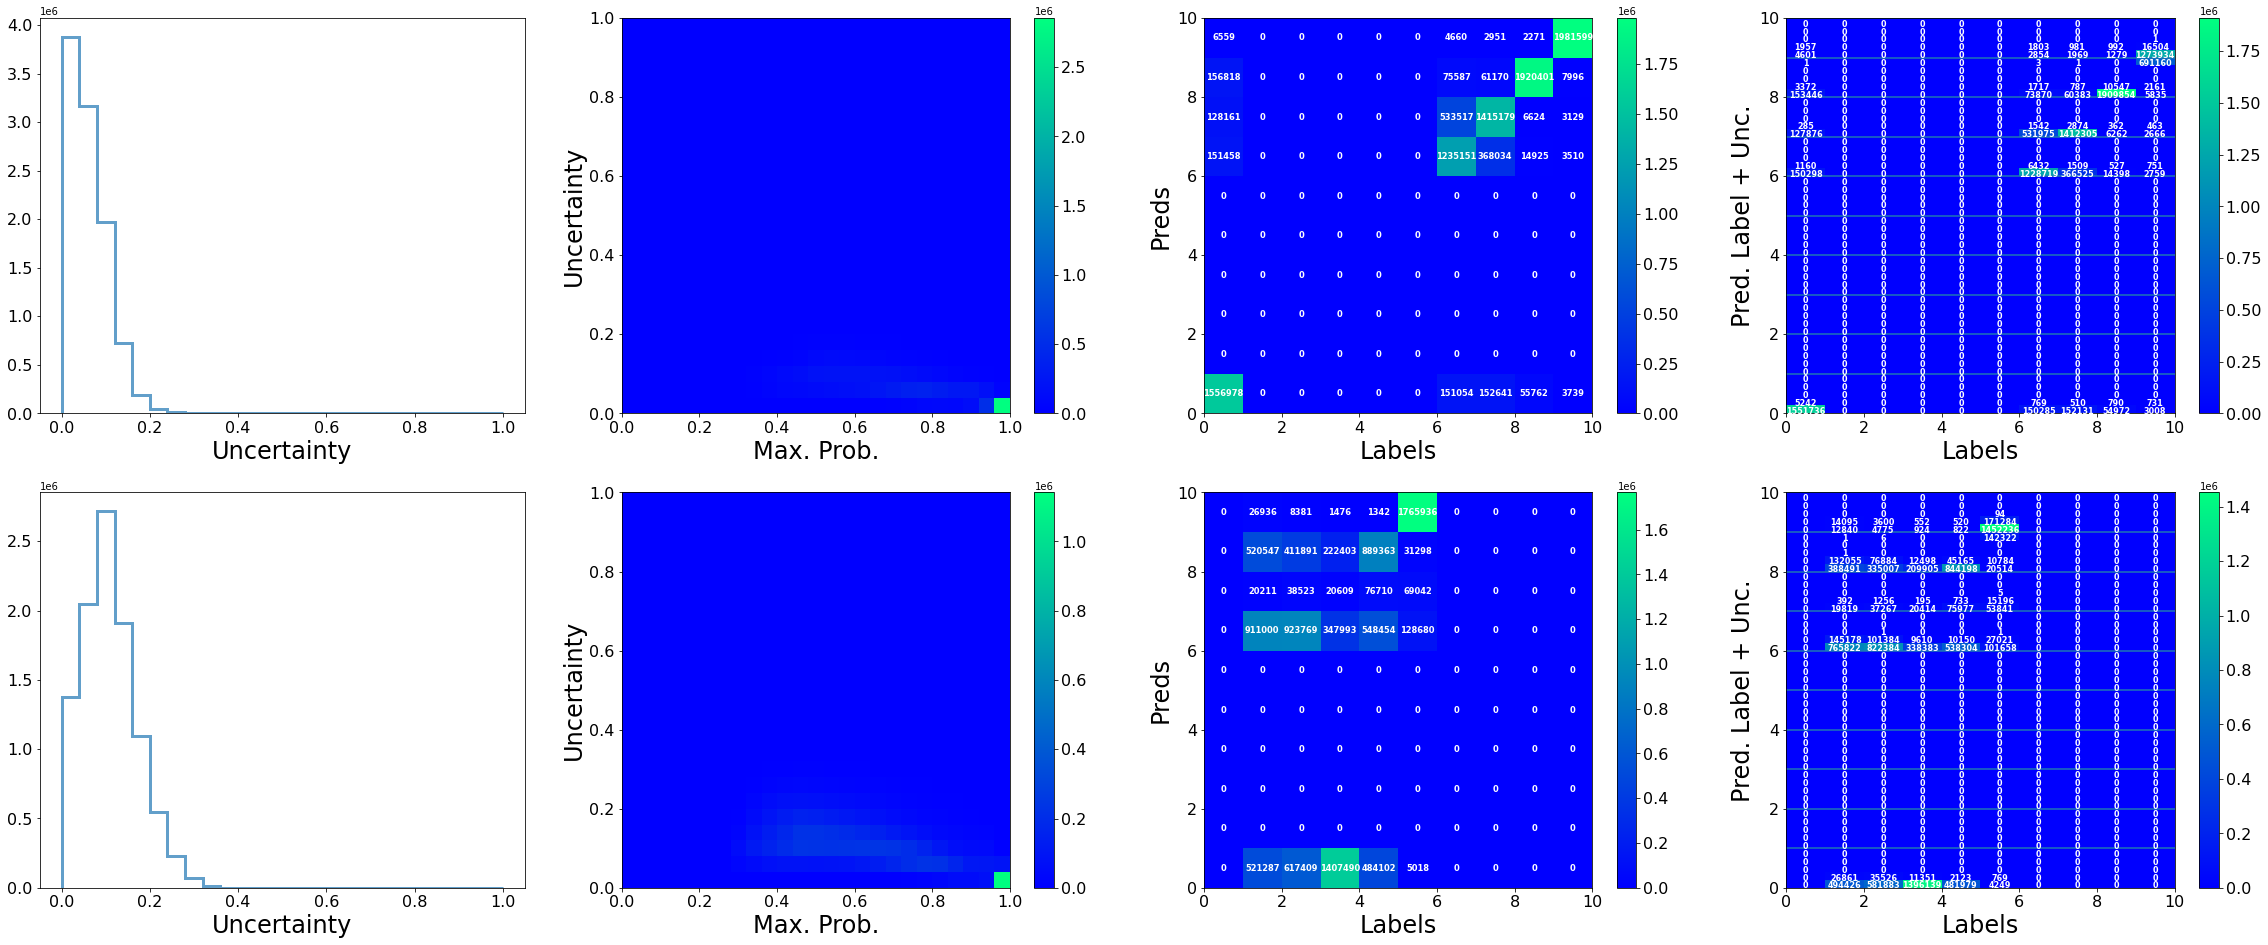

MCDO_jetclass_skiptop


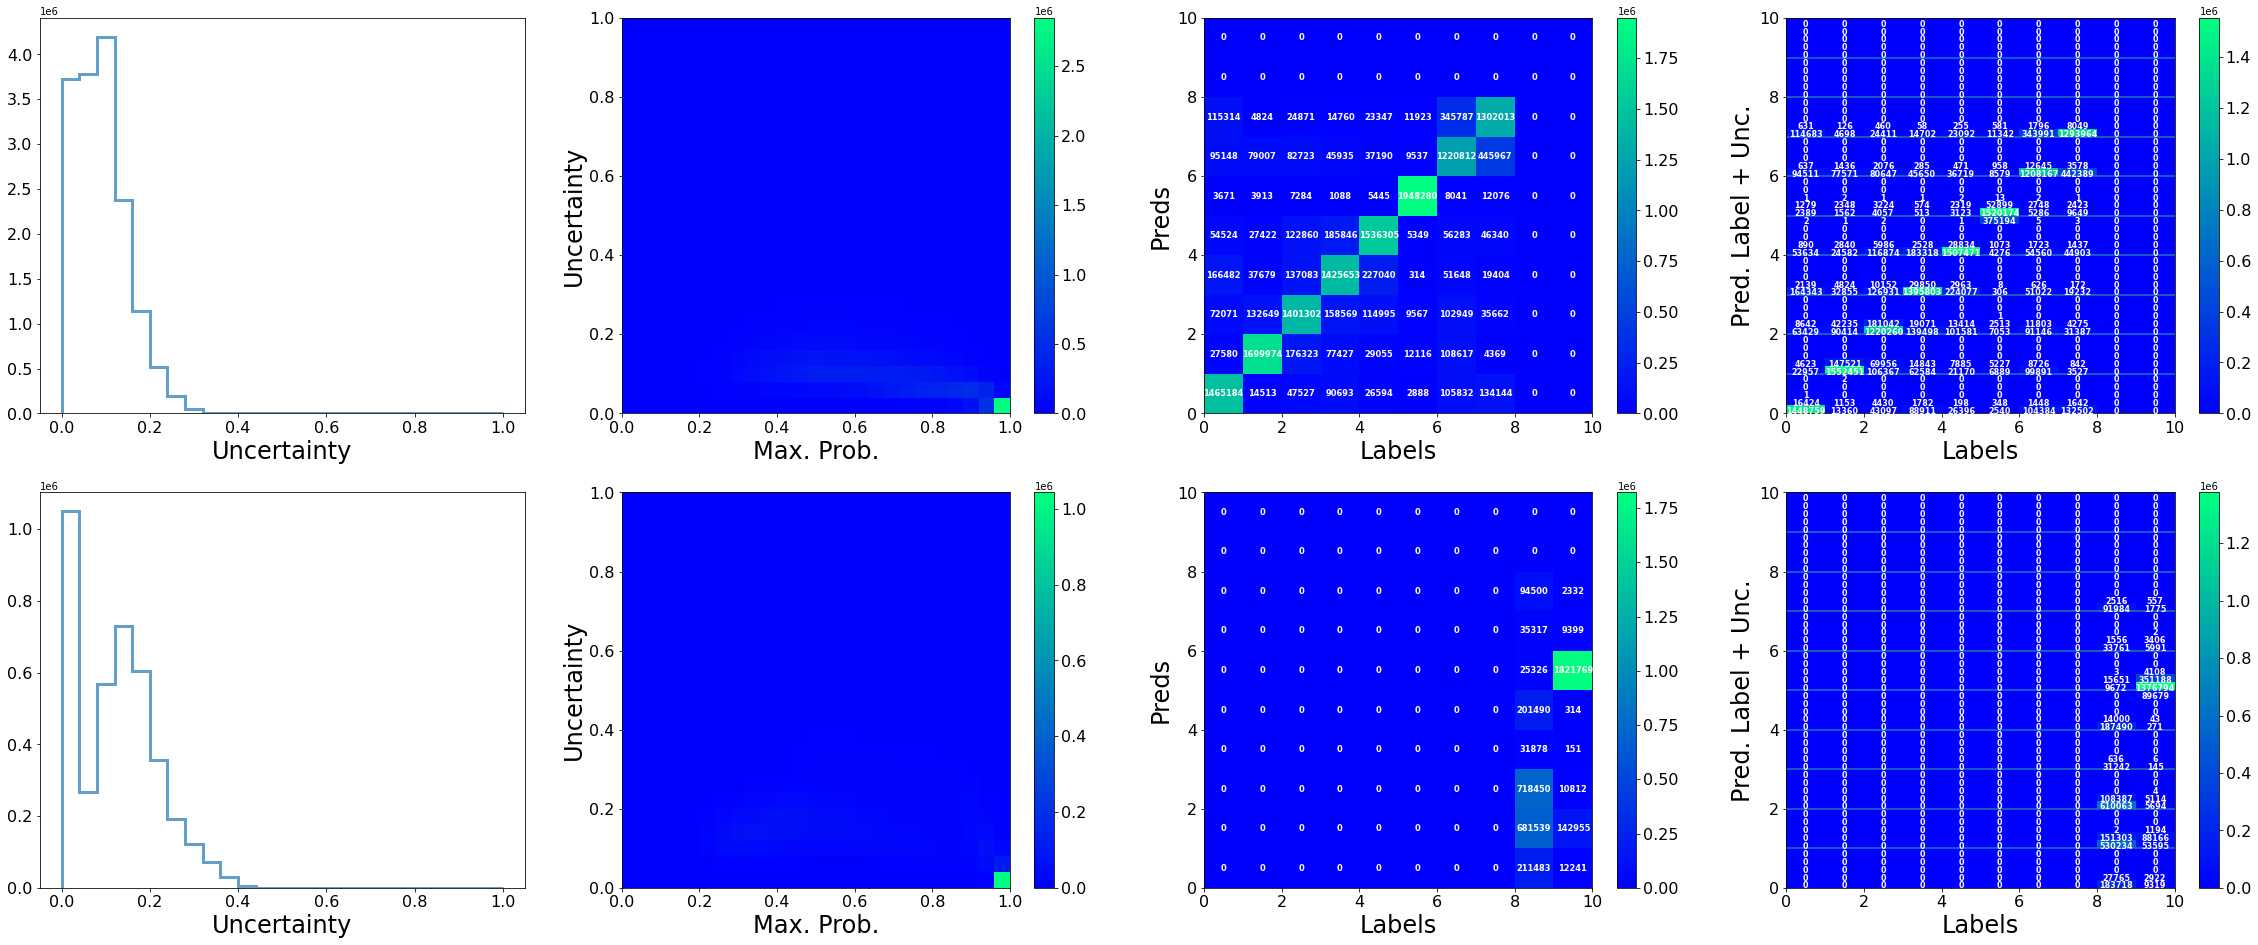

MCDO_jetclass_skiptwz


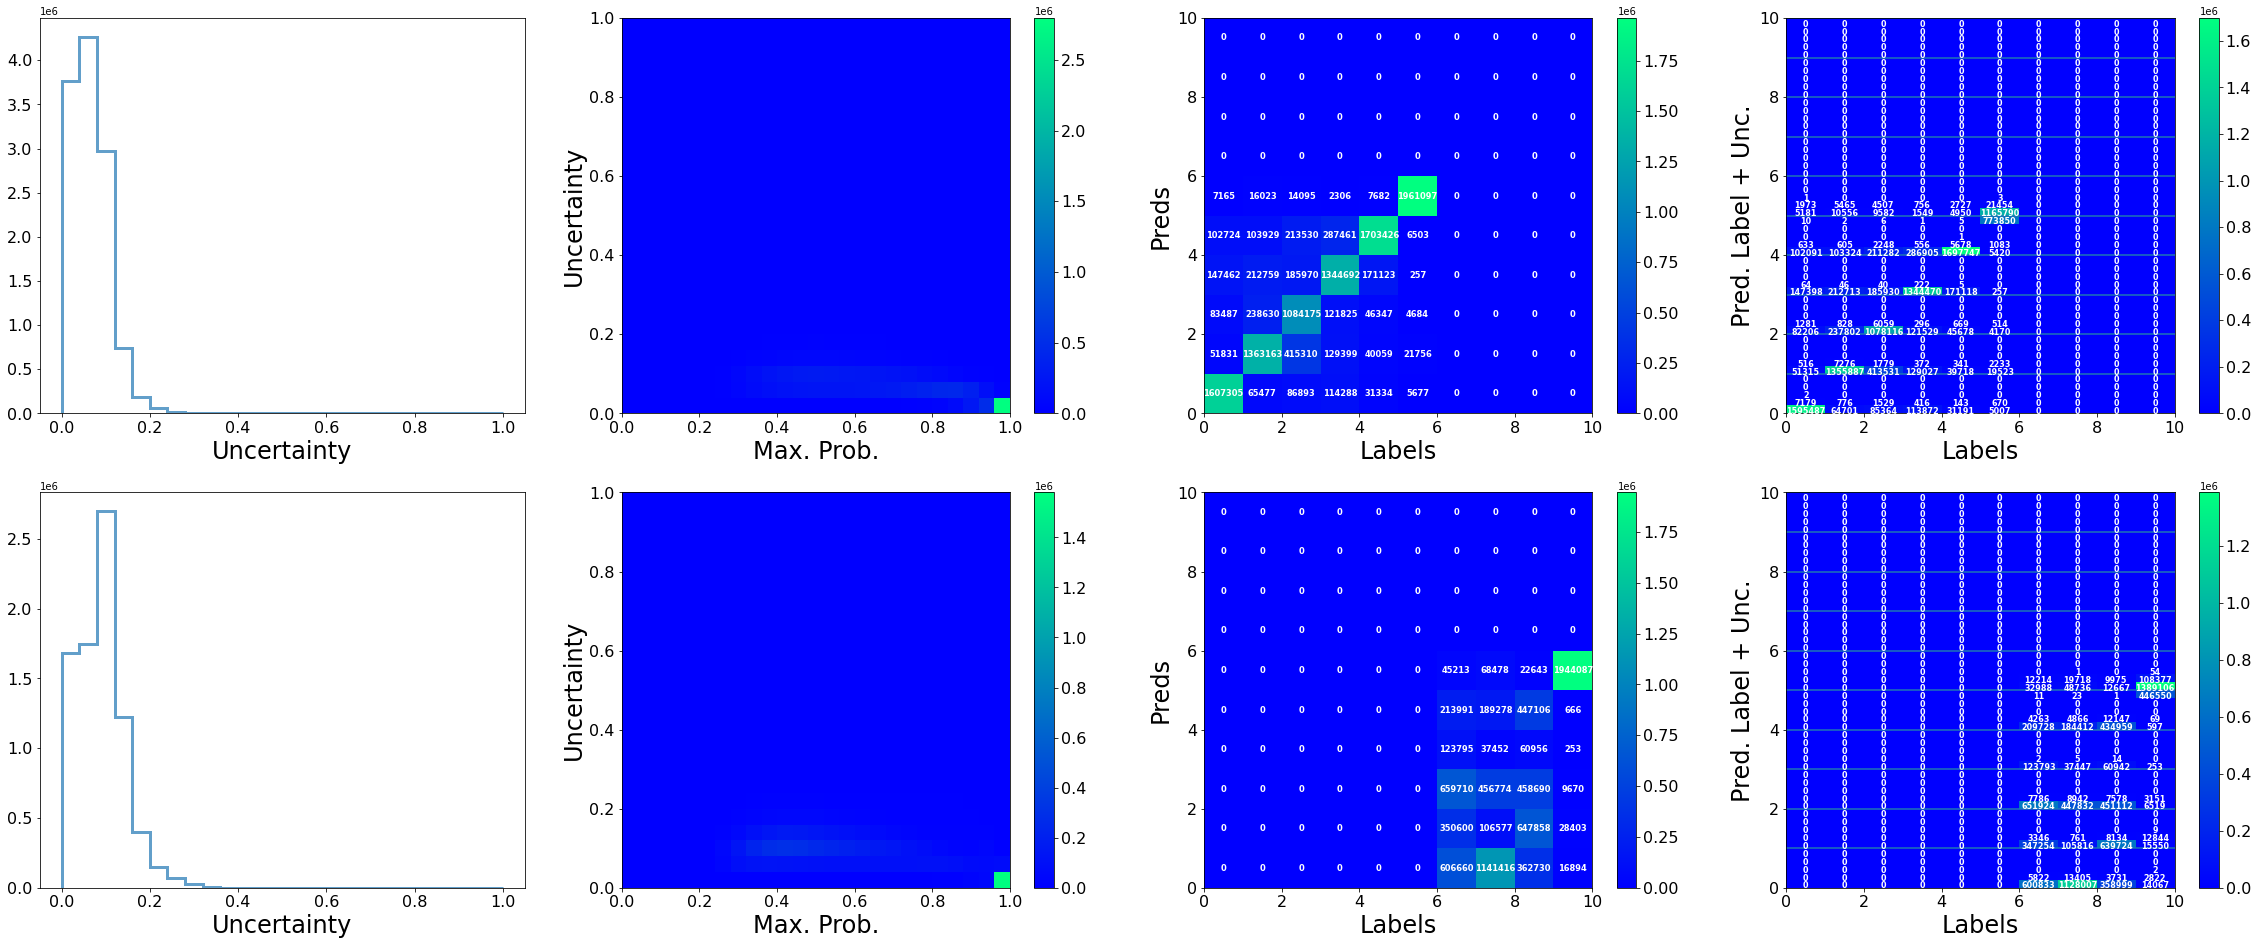

MCDO_jetclass_skipwz


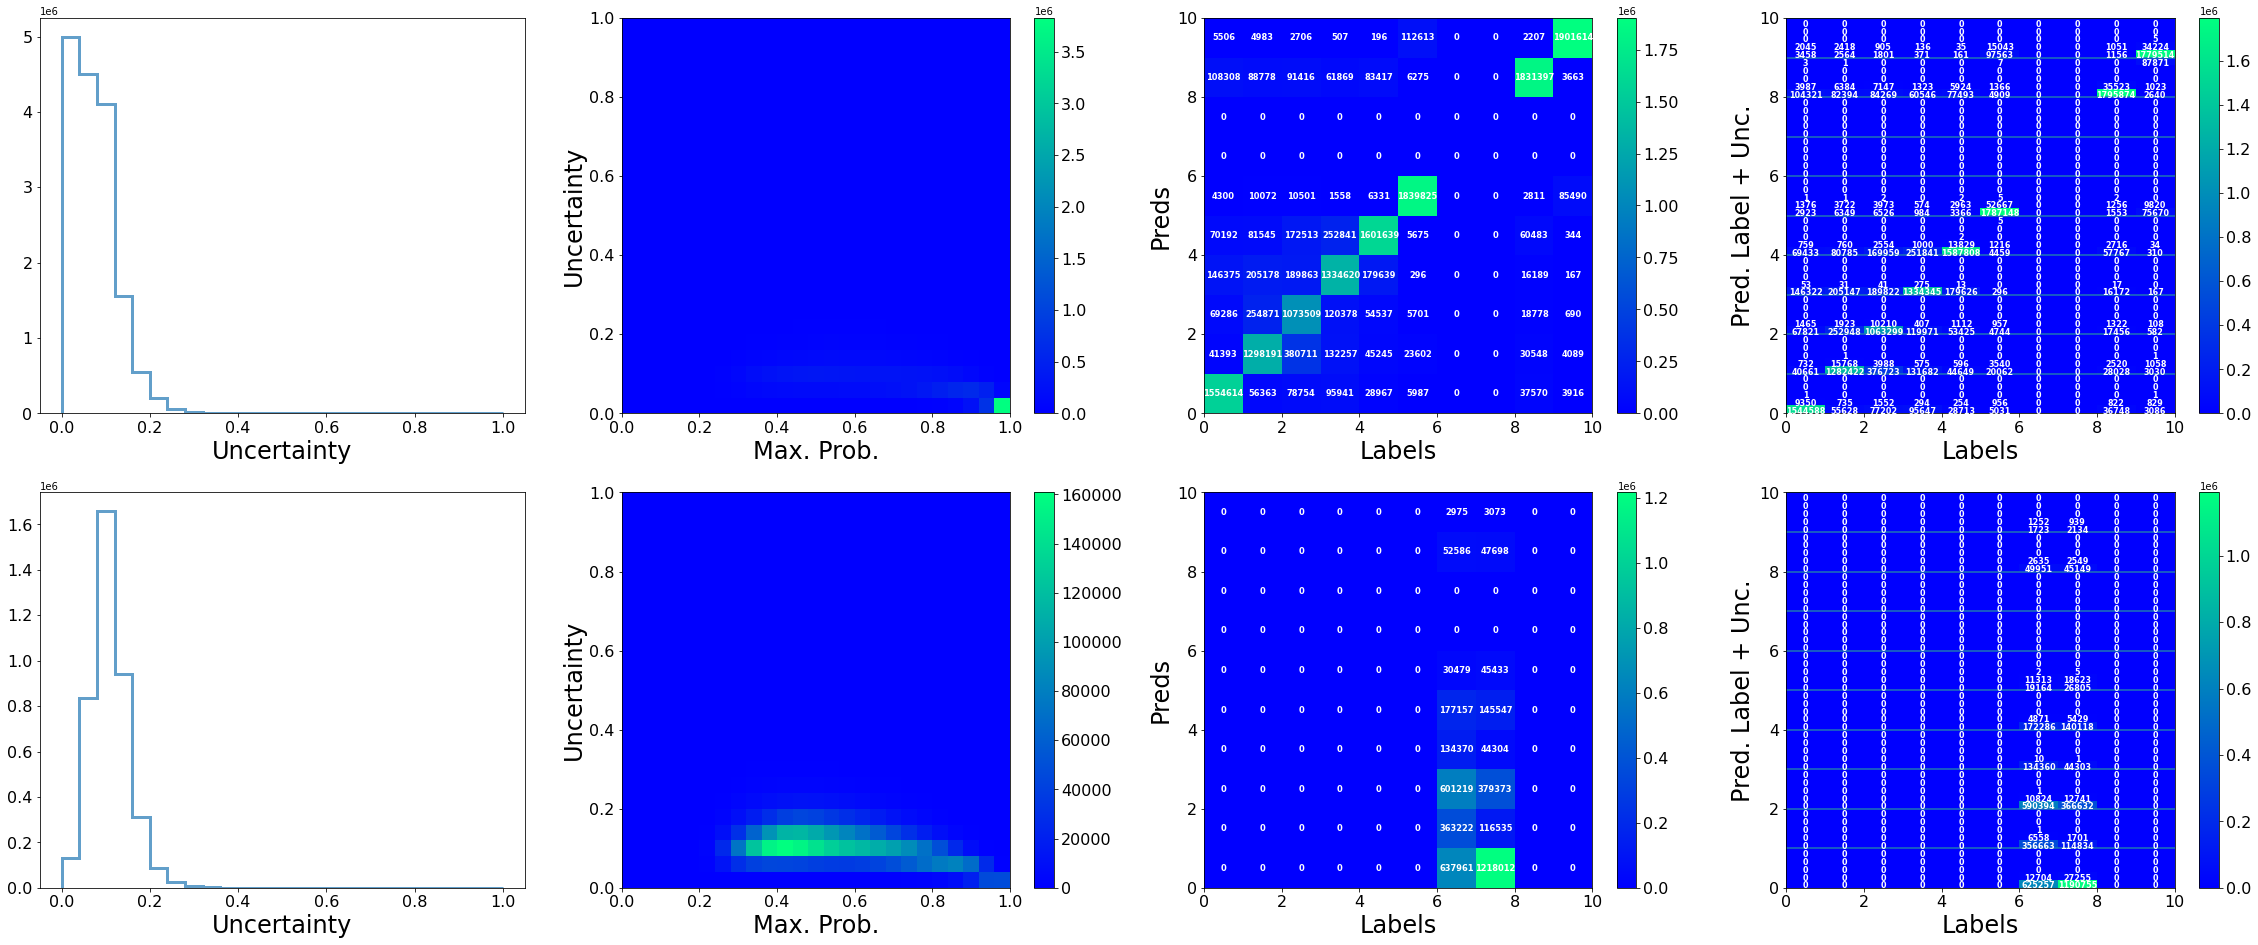

In [12]:
for modelname in result_files:
    key = modelname[15:-3]
    print(key)
    if "jetnet" in key:
        l_max = 5.1
        asize=16
        asize2=12
        
    elif "jetclass" in key:
        l_max = 10.1
        asize="small"
        asize2=8
    
    elif "JNqgmerged" in key:
        l_max = 4.1
    else:
        l_max = 2.1
        asize=32
        asize2=20
    
    filename = os.path.join(results_dir, modelname)
    
    f = h5py.File(filename, "r")    
    labels, preds, maxprobs, sums, oods, uncs, probs = f['labels'][:], f['preds'][:], \
                                                f['maxprobs'][:], f['sums'][:], \
                                                f['oods'][:], f['uncs'][:], f['probs'][:]
    f.close()
    
    fsize=24
    tsize=16
    
    #epistemic uncertainty
    uncertainty_plot(uncs, oods, maxprobs, labels, preds, key, l_max, fsize, tsize, asize, asize2)
    # plt.savefig("figures/MCDO_{}.pdf".format(key))
    plt.show()